In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re #A regular expression is a method used in programming for pattern matching. Regular expressions provide a flexible and concise means to match strings of text. ... Regular expressions are also known in short form as regex or regexp. import nltk import string from nltk.corpus import stopwords from nltk.stem import WordNetLemmatizer, SnowballStemmer from nltk.stem.porter import PorterStemmer from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Classification evaluation
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
#Word Cloud
from wordcloud import WordCloud, STOPWORDS

In [36]:
import tensorflow as tf
from tensorflow import keras 

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dropout, Activation, Input, Dense, concatenate
from keras.layers.embeddings import Embedding
from tensorflow.keras.initializers import Constant

In [38]:
dataset = pd.read_csv('sentimate_train_2kmZucJ.xls')
dataset_test = pd.read_csv('sentimate_test_oJQbWVk.csv.xls')
dataset.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [39]:
dataset_test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
id       7920 non-null int64
label    7920 non-null int64
tweet    7920 non-null object
dtypes: int64(2), object(1)
memory usage: 185.7+ KB


In [41]:
#let’s first combine train and test set. This saves the trouble of performing the same steps twice on test and train.
combi = dataset.append(dataset_test, ignore_index=True)

In [42]:
#function to remove unwanted text patterns from the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [43]:
# remove special characters, numbers, punctuations
combi['tweet'] = combi['tweet'].str.replace("[^a-zA-Z#]", " ")# [^a-zA-Z] means any character that IS NOT a-z OR A-Z.


In [44]:
#Removing short word
combi['tweet'] = combi['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [45]:
    combi.head

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https MfQV #andro...
1,2,0.0,Finally transparant silicon case Thanks uncle ...
2,3,0.0,love this Would #talk #makememories #unplug #r...
3,4,0.0,wired know George made that #iphone #cute #dav...
4,5,1.0,What amazing service Apple even talk about que...


In [46]:
#Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [47]:
tokenized_tweet = combi['tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [#fingerprint, #Pregnancy, Test, https, MfQV, ...
1    [Finally, transparant, silicon, case, Thanks, ...
2    [love, this, Would, #talk, #makememories, #unp...
3    [wired, know, George, made, that, #iphone, #cu...
4    [What, amazing, service, Apple, even, talk, ab...
Name: tweet, dtype: object

In [48]:
#Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.tokens jdjdjdj 

In [49]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [#fingerprint, #pregnanc, test, http, mfqv, #a...
1    [final, transpar, silicon, case, thank, uncl, ...
2    [love, thi, would, #talk, #makememori, #unplug...
3    [wire, know, georg, made, that, #iphon, #cute,...
4    [what, amaz, servic, appl, even, talk, about, ...
Name: tweet, dtype: object

In [50]:
#Now let’s stitch these tokens back together

In [51]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tweet'] = tokenized_tweet

In [52]:
#Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

In [53]:
#A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.
#Let’s visualize all the words our data using the wordcloud plot. 

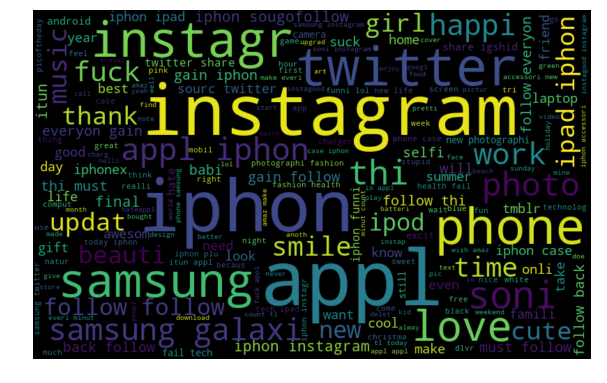

In [54]:
    all_words = ' '.join([text for text in combi['tweet']])
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [55]:
#We can see most of the words are positive or neutral. With happy and love being the most frequent ones. It doesn’t give us any idea about the words associated with the Negative tweets. Hence, we will plot separate wordclouds for both the classes(Negative or not) in our train data.

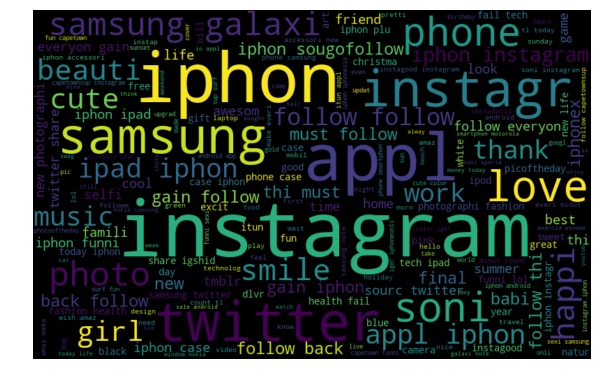

In [56]:
normal_words =' '.join([text for text in combi['tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

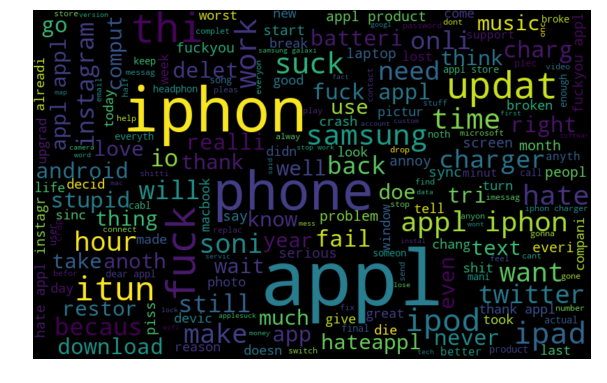

In [57]:
negative_words = ' '.join([text for text in combi['tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [58]:
#As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.
# Understanding the impact of Hashtags on tweets sentiment

In [59]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [60]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [64]:
#Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top n hashtags. So, first let’s check the hashtags in the Negative tweets.
import seaborn as sns
import nltk

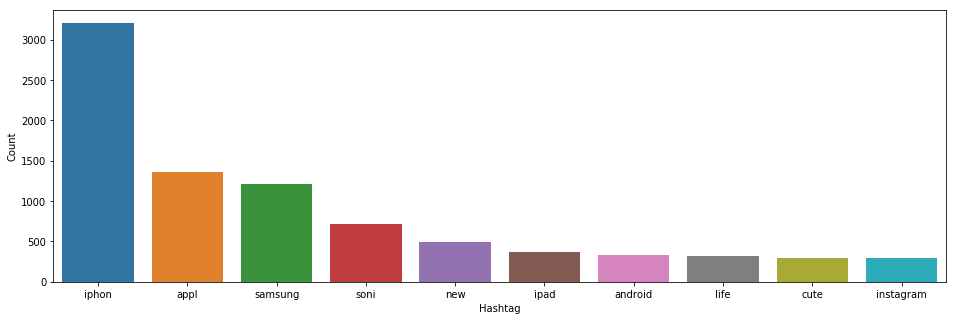

In [65]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [66]:
#All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the Negative tweets.

In [67]:
#Negative tweets

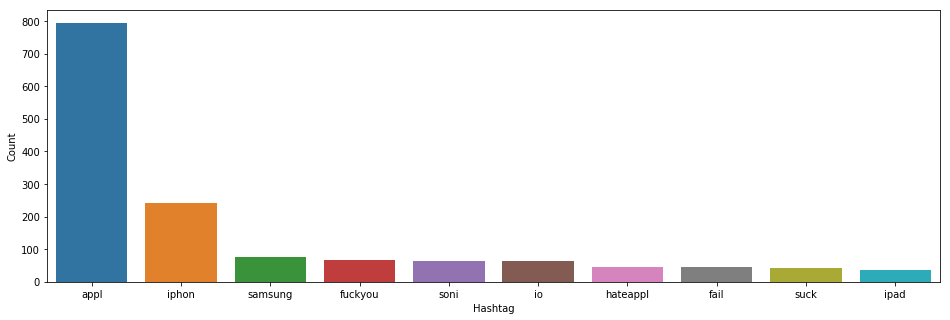

In [68]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [69]:
#As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

In [70]:
#4. Extracting Features from Cleaned Tweets
#To analyze a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques
#– Bag-of-Words, TF-IDF, and Word Embeddings. In this article, we will be covering only Bag-of-Words and TF-IDF.

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tweet'])

In [72]:
#TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

In [73]:
#Let’s have a look at the important terms related to TF-IDF:
#TF = (Number of times term t appears in a document)/(Number of terms in the document)
#IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
#TF-IDF = TF*IDF

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tweet'])

In [75]:
# Model Building: Sentiment Analysis

In [76]:
#We are now done with all the pre-modeling stages required to get the data in the proper form and shape. Now we will be building predictive models on the dataset using the two feature set — Bag-of-Words and TF-IDF.

In [77]:
#We will use logistic regression to build the models. It predicts the probability of occurrence of an event by fitting data to a logit function.

In [78]:
# Building model using Bag-of-Words features

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:7920,:]
test_bow = bow[7920:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, dataset['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

    f1_score(yvalid, prediction_int) # calculating f1 score

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8050314465408805

In [80]:
#We trained the logistic regression model on the Bag-of-Words features and it gave us an F1-score of 0.80 for the validation set. Now we will use this model to predict for the test data.

In [81]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
dataset_test['label'] = test_pred_int
submission = dataset_test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [82]:
#Building model using TF-IDF features

In [83]:
train_tfidf = tfidf[:7920,:]
test_tfidf = tfidf[7920:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8200138985406532

In [84]:
#The validation score is 0.82 and the public leaderboard F1 score is **. So, by using the TF-IDF features, the validation score has improved and the public leaderboard score is more or less the same. 